In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Building and training of PINN
from PINN_2D_Laplace import PhysicsInformedNN
# from PINN_2D_General import PhysicsInformedNN

from scipy.interpolate import griddata
from scipy.stats import qmc

# Geometry and grid
import pygmsh
# import meshio

import time

# Solution of the Laplace Equation in a inrregular domain (square - circle)


In [3]:
N_f = 400
N_u_sqr = 40
N_u_cir = 20

# .----------------------------------------------.
# |           MALLA: DOMINIO 2D                  |
# .______________________________________________.

# Definición del dominio: [-1, 1] x [-1, 1]
xIni = -1.0; xFin = 1.0
yIni = -1.0; yFin = 1.0

# Malla para entrenamiento
x = np.linspace(xIni, xFin, num=100)
y = np.linspace(yIni, yFin, num=100)
X, Y = np.meshgrid(x, y)

# .----------------------------------------------.
# |     PUNTOS DE ENTRENAMIENTO Y COLOCACIÓN     |
# .______________________________________________.

# [0] Puntos de frontera del cuadrado (con valores exactos)
xx1 = np.hstack((X[0:1, :].T, Y[0:1, :].T))     # y = -1
xx2 = np.hstack((X[:, 0:1], Y[:, 0:1]))         # x = -1
xx3 = np.hstack((X[:, -1:], Y[:, -1:]))         # x = 1
xx4 = np.hstack((X[-1:, :].T, Y[-1:, :].T))     # y = 1

X_bdy_sqr = np.vstack([xx1, xx2, xx3, xx4])

# [1] Puntos de colocalización en el dominio interior
X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))
lb = X_star.min(0)  # cota inferior
ub = X_star.max(0)  # cota superior

lhs = qmc.LatinHypercube(d=2)
X_f = lb + (ub-lb)*lhs.random(n = N_f)  # LHS muestreo (Latin Hypercube)
X_f_train = np.vstack(X_f)

xf = X_f_train[:, 0:1]
yf = X_f_train[:, 1:2]

# Quitar los puntos que esten dentro del circulo
r = 0.5 
norm = np.sqrt(xf**2 + yf**2)
outside = np.where(norm > r)[0] # Criterio

xf = xf[outside]
yf = yf[outside]

# Frontera interior o del círculo
theta = np.linspace(0, 2*np.pi, N_u_sqr)
X_bdy_cir = np.array([r*np.cos(theta), r*np.sin(theta)]).T

# Lado derecho: f(x,y) = 0
rhs = np.zeros((N_f, 1))
rhs_train = rhs

# [2] Selección aleatoria de puntos de frontera para entrenar
idx_sqr = np.random.choice(X_bdy_sqr.shape[0], N_u_sqr, replace=False)
idx_cir = np.random.choice(X_bdy_cir.shape[0], N_u_cir, replace=False)

X_u_train = np.concat([ X_bdy_sqr[idx_sqr, :], X_bdy_cir[idx_cir, :]])

xu = X_u_train[:, 0]
yu = X_u_train[:, 1]

In [4]:
# Solución en los puntos de la frontera para entrenar
u_train = np.exp(xu) * np.cos(yu)
u_train.shape, X_u_train.shape

((60,), (60, 2))

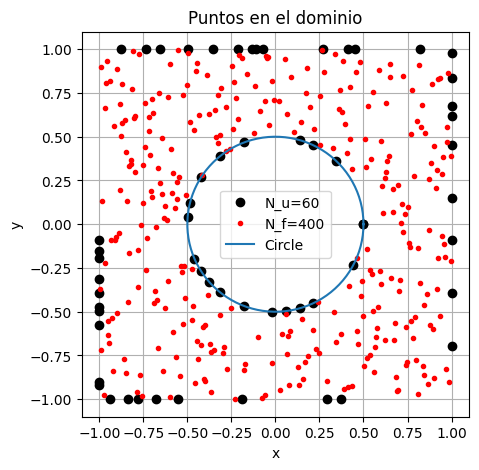

In [5]:
#Distribución de puntos de entrenamiento
fig = plt.figure(figsize = (5,5))
str1 = f'N_u={N_u_sqr + N_u_cir}'
str2 = f'N_f={N_f}'

plt.plot(xu, yu, 'ok', label=str1) # Boundry
plt.plot(xf, yf, '.r', label=str2) # Latin HyperCube

# Círculo interior
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(r*np.cos(theta), r*np.sin(theta), label = 'Circle')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos en el dominio')
plt.legend()
plt.grid(True)

plt.show()

# Data processing for PINN

In [9]:
#======================================================================#
#                        RUTINA PARA LA SOLUCIÓN                       #
# ---------------------------------------------------------------------#
# Este script entrena una red neuronal para resolver un problema       #
# elíptico bidimensional mediante el enfoque de PINNs. Se usan puntos  #
# de frontera para entrenar la condición de frontera y puntos de       #
# colocación aleatorios para imponer la PDE                            #
#======================================================================#

if __name__ == "__main__":  
    
    #-------------------------------
    N_bdy_sqr = 40 # Puntos de frontera del cuadrado
    N_bdy_cir = 20 # Puntos de frontera del circulo

    N_bdy = N_bdy_sqr + N_bdy_cir
    
    N_int = 200   # Puntos de colocación en el dominio interior

    Ne = 20        # Neuronas por capa oculta

    coef = [1, 0 , 1, 0, 0, 0] # Coeficientes de la PDE: Laplace
    
    layers = [2, Ne, Ne, Ne, 1]  # Arquitectura: entrada, 3 ocultas, salida
    epochs = 3000

    #-------------------------------
    # Mostrar resumen de parámetros en consola
    print('  ')
    print('---------------------------------------------')
    print('              PROBLEMA ELÍPTICO              ')
    print('---------------------------------------------')
    print('  ENTRENAMIENTO:                             ')
    print('  Puntos de frontera          N_bdy =', N_bdy)
    print('  Puntos de colocalización    N_int =', N_int)
    print('---------------------------------------------')
    print('  RED NEURONAL:                             ')
    print('  Capas =', layers)
    print('---------------------------------------------')
    print('  ')

    # .----------------------------------------------.
    # |           MALLA: DOMINIO 2D                  |
    # .______________________________________________.

    # ===========================================================
    # 1. Parámetros del Lavadora
    # ===========================================================
    r = 0.5             # radio del círculo interior
    mesh_size = 0.2     # tamaño característico

    # ===========================================================
    # 2. Geometría con API moderna de pygmsh
    # ===========================================================
    with pygmsh.geo.Geometry() as geom:
        # --- Cuadrado externo [-1,1]x[-1,1] ---
        p1 = geom.add_point([-1, -1, 0], mesh_size)
        p2 = geom.add_point([ 1, -1, 0], mesh_size)
        p3 = geom.add_point([ 1,  1, 0], mesh_size)
        p4 = geom.add_point([-1,  1, 0], mesh_size)

        l1 = geom.add_line(p1, p2)
        l2 = geom.add_line(p2, p3)
        l3 = geom.add_line(p3, p4)
        l4 = geom.add_line(p4, p1)
        outer_loop = geom.add_curve_loop([l1, l2, l3, l4])

        # --- Círculo interno (agujero) ---
        center = geom.add_point([0, 0, 0], mesh_size)
        n_circle = 60
        pts_circle = [geom.add_point([r*np.cos(t), r*np.sin(t), 0], mesh_size)
                  for t in np.linspace(0, 2*np.pi, n_circle, endpoint=False)]
        lines_circle = [geom.add_line(pts_circle[i], pts_circle[(i+1)%n_circle])
                    for i in range(n_circle)]
        inner_loop = geom.add_curve_loop(lines_circle)

        # --- Superficie con agujero ---
        surface = geom.add_plane_surface(outer_loop, [inner_loop])

        # (Opcional) Etiquetas físicas
        geom.add_physical(surface, "domain")
        geom.add_physical(outer_loop, "outer_boundary")
        geom.add_physical(inner_loop, "inner_boundary")

        mesh = geom.generate_mesh()

    # ===========================================================
    # 3. Extraer datos
    # ===========================================================
    points = mesh.points[:, :2]
    cells  = mesh.get_cells_type("triangle")

    # ===========================================================
    # 4. Clasificar nodos frontera/interior
    # ===========================================================
    boundary = mesh.get_cells_type("line")
    bdy_pts = np.unique(boundary)

    # Puntos de la frontera
    x_bdy = points[bdy_pts, 0]
    y_bdy = points[bdy_pts, 1]

    all_indices = np.arange(points.shape[0])
    int_pts = np.setdiff1d(all_indices, bdy_pts)

    # Puntos del interior
    x_int = points[int_pts,0]
    y_int = points[int_pts,1]
    
    # Puntos del Mesh
    xp = points[:,0]
    yp = points[:,1]

    # .----------------------------------------------.
    # |       SOLUCIÓN EXACTA (para referencia)      |
    # .______________________________________________.

    # Generar solución exacta en malla de entrenamiento
    N = len(xp)
    up_star = np.zeros(N)
    for i in range(N):
        up_star[i] = np.exp(xp[i]) * np.cos(yp[i])

    Xp_star = np.vstack([xp, yp]).T # Cambio relevante
    
    # .----------------------------------------------.
    # |     PUNTOS DE ENTRENAMIENTO Y COLOCACIÓN     |
    # .______________________________________________.

    xl, xr = -1, 1
    yd, yu = -1, 1

    # Número de nodos por lado
    n = N_bdy_sqr//4

    # Muestreo sobre la dirección horizontal y vertical
    h = np.random.uniform(low = xl, high = xr, size = 2*n)
    v = np.random.uniform(low = yd, high = yu, size = 2*n)

    # Construcción de los lados
    l1 = np.array( [xr*np.ones(n), v[:n] ] ).T
    l2 = np.array( [h[:n], yd*np.ones(n) ] ).T
    l3 = np.array( [xl*np.ones(n), v[n:] ] ).T
    l4 = np.array( [h[n:], yu*np.ones(n) ] ).T

    # Agrupamiento de los puntos de frontera aleatorios
    X_bdy_sqr = np.concatenate([l1, l2, l3, l4])

    # Muestreo interior
    lhs = qmc.LatinHypercube(d=2)
    X_f = lhs.random(n = N_int)  # LHS muestreo (Latin Hypercube)
    X_f_train = np.vstack(X_f)

    # Quitar los puntos que esten dentro del circulo
    r = 0.5 
    norm = np.sqrt(X_f_train[:, 0]**2 + X_f_train[:, 1]**2)
    outside = np.where(norm > r)[0] # Criterio

    X_f_train = X_f_train[outside]

    xf = X_f_train[:, 0]
    yf = X_f_train[:, 1]
    
    # Frontera interior o del círculo
    theta = np.random.uniform(0, 2*np.pi, N_bdy_sqr)
    X_bdy_cir = np.array([r*np.cos(theta), r*np.sin(theta)]).T

    # Cóndiciones de frontera totales
    X_u_train = np.concat([ X_bdy_sqr, X_bdy_cir])

    # Lado derecho: f(x,y) = 0
    N_int = X_f_train.shape[0]
    rhs = np.zeros((N_int, 1))
    rhs_train = rhs

    # Implementación de la condición de Dirichelet
    xu = X_u_train[:, 0]
    yu = X_u_train[:, 1]

    # Condiciones de Dirichlet; solución
    u_train = np.array([np.exp(xu) * np.cos(yu)]).T
    
    # .================================================================.
    # | [S.2]                  APROXIMACIÓN                            |
    # .================================================================.

    # .----------------------------------------------.
    # |     ENTRENAMIENTO DEL MODELO (PINN)          |
    # .______________________________________________.

    #  Construcción de la red neuronal con condiciones físicas
    model = PhysicsInformedNN(X_u_train, u_train,
                              X_f_train, rhs_train,
                              layers, epochs, 1e-3)

    # Entrenamiento de la red neuronal
    start_time = time.time()
    model.train()
    elapsed = time.time() - start_time

    # .----------------------------------------------.
    # |         PREDICCIÓN SOBRE NUEVA MALLA         |
    # .______________________________________________.

    up_pred = model.predict(Xp_star).reshape(N)   # un solo vector de predicciones

    # .----------------------------------------------.
    # |     CÁLCULO DE ERRORES L2 Y MÁXIMO           |
    # .______________________________________________.

    error_u   = np.linalg.norm(up_star - up_pred, 2) / np.linalg.norm(up_star, 2)
    error_max = np.linalg.norm(up_star - up_pred, np.inf)

    # .================================================================.
    # | [S.3]              VISUALIZACIÓN DE RESULTADOS                 |
    # .================================================================.

    print('---------------------------------------------')
    print('  ENTRENAMIENTO:                             ')
    print('  Puntos de entrenamiento     N_train =', N_bdy)
    print('  Puntos de colocalización    N_int =', N_int)
    print('---------------------------------------------')
    print('  RED NEURONAL:                             ')
    print('  Capas =', layers)
    print('---------------------------------------------')
    print('   N_bdy    N_int    Norma L2       Norma máx')
    print('  %3s   %3s   %e    %e' % (N_bdy, N_int, error_u, error_max))
    print('---------------------------------------------')
    print('  Tiempo de entrenamiento: %.4f segundos' % (elapsed))
    print('---------------------------------------------')
    print('  ')

  
---------------------------------------------
              PROBLEMA ELÍPTICO              
---------------------------------------------
  ENTRENAMIENTO:                             
  Puntos de frontera          N_bdy = 60
  Puntos de colocalización    N_int = 200
---------------------------------------------
  RED NEURONAL:                             
  Capas = [2, 20, 20, 20, 1]
---------------------------------------------
  
Epoch 0, Loss: 1.78320e+00,  U_loss: 1.74018e+00, f_loss: 4.30137e-02
Epoch 100, Loss: 1.00588e-01,  U_loss: 9.50910e-02, f_loss: 5.49722e-03
Epoch 200, Loss: 9.05246e-02,  U_loss: 8.50899e-02, f_loss: 5.43466e-03
Epoch 300, Loss: 8.12903e-02,  U_loss: 7.65892e-02, f_loss: 4.70110e-03
Epoch 400, Loss: 6.97996e-02,  U_loss: 6.57316e-02, f_loss: 4.06801e-03
Epoch 500, Loss: 5.62052e-02,  U_loss: 5.19423e-02, f_loss: 4.26288e-03
Epoch 600, Loss: 4.45590e-02,  U_loss: 3.80220e-02, f_loss: 6.53694e-03
Epoch 700, Loss: 3.49171e-02,  U_loss: 2.80383e-02, f_loss:

# Graphs for the problem

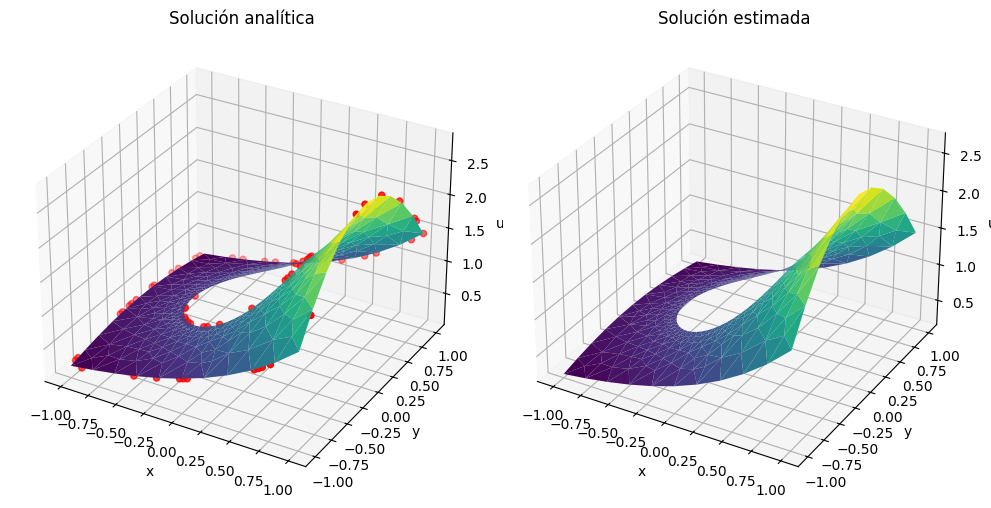

In [54]:
import matplotlib.pyplot as plt                  # Generación de gráficos 2D
from mpl_toolkits.mplot3d import Axes3D          # Gráficos 3D con matplotlib

# .----------------------------------------------.
#  Graficar resultados
# .----------------------------------------------.
#  - Subplot 1: Solución analítica
#  - Subplot 2: Solución predicha
#  - Subplot 3: Distribución de puntos
#  - Subplot 4: Malla de GMesh
fig = plt.figure(figsize=(10, 5))

# Subplot 1: Solución analítica
ax1 = fig.add_subplot(221, projection='3d')

ax1.plot_trisurf(xp, yp, up_star, triangles=cells, cmap='viridis', linewidth=0.2, antialiased=True)
ax1.scatter(X_u_train[:,0], X_u_train[:,1], u_train[:,0], color = 'red')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('uA')
ax1.set_title('Solución analítica')

# Subplot 2: Solución estimada por la red
ax2 = fig.add_subplot(222, projection='3d')

ax2.plot_trisurf(xp, yp, up_pred, triangles=cells, cmap='viridis', linewidth=0.2, antialiased=True)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('uN')
ax2.set_title('Solución estimada')

# Subplot 3: Distribución de puntos de entrenamiento

ax3 = fig.add_subplot(223)
str1 = f'N_u={N_bdy}'
str2 = f'N_f={N_int}'

ax3.plot(xu, yu, 'ok', label=str1) # Boundry
ax3.plot(xf, yf, '.r', label=str2) # Latin HyperCube

ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('Puntos de entrenamiento')
ax3.set_aspect('equal')
ax3.legend()
ax3.grid(True)

# Subplot 4: Distribución de puntos de prueba

ax4 = fig.add_subplot(224)

ax4.triplot(xp, yp, cells, lw=0.5, color='gray')
ax4.scatter(x_int, y_int,
            color='blue', s=10, label='Nodos interiores')
ax4.scatter(x_bdy, y_bdy,
            color='red', s=25, label='Nodos de frontera')
ax4.set_aspect('equal')

ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_title("Malla triangular tipo Gmsh con pygmsh")
ax4.legend()

plt.tight_layout()
# plt.savefig('Act7_graphs.png')
plt.show()

## Absolute error

In [11]:
loss_h, u_loss_h, f_loss_h = model.history()

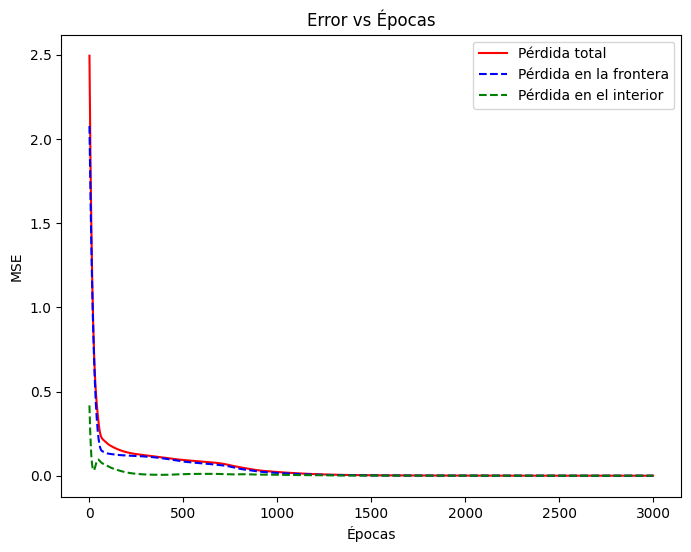

In [34]:
fig = plt.figure(figsize=(8, 6))

plt.plot(range(epochs), loss_h, '-r', label='Pérdida total')
plt.plot(range(epochs), u_loss_h, '--b', label='Pérdida en la frontera')
plt.plot(range(epochs), f_loss_h, '--g', label='Pérdida en el interior')
plt.title('Error vs Épocas')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.savefig('Act6_Epochs.png')
plt.show()

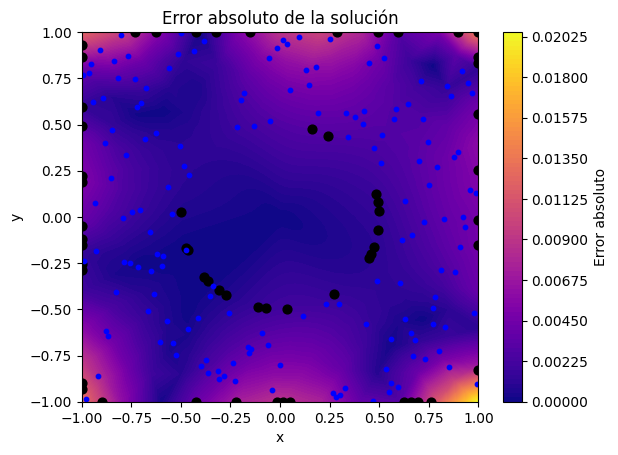

In [36]:
# Subplot 5: Mapa de calor del error
err = np.abs(up_star - up_pred) #Error absoluto

plt.tricontourf(xp, yp, err, levels=100, cmap='plasma')
plt.colorbar(label='Error absoluto')

# Puntos de la frontera
plt.scatter(xu, yu,
            color='black', s=40, label='Nodos de frontera')

plt.scatter(xf, yf, color='blue', s=10, label='Nodos interiores')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Error absoluto de la solución')

plt.savefig('Act6_Err.png')
plt.show()